<a href="https://colab.research.google.com/github/kiberbull/AZSII/blob/main/prz3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ASZI')
os.getcwd()


'/content/drive/MyDrive/Colab Notebooks/ASZI'

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot encoding
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Проверка точности модели на тестовых данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy on clean images: {test_acc}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1056 - loss: 2.3705
Test accuracy on clean images: 0.11259999871253967


In [4]:
!pip install foolbox

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tf.Tensor(7, shape=(), dtype=int64)


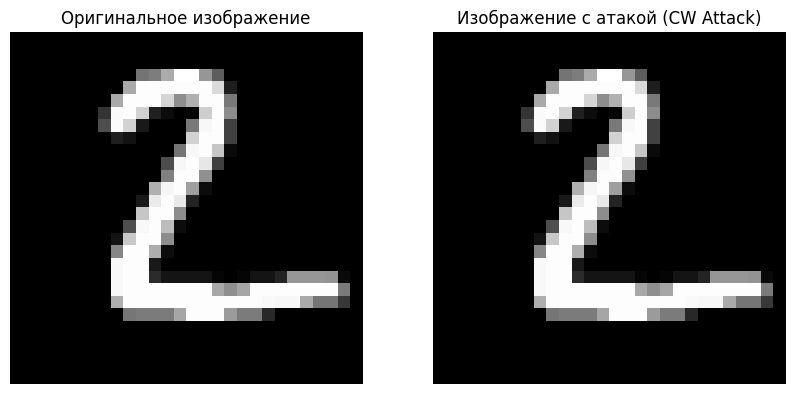

In [5]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Создание модели для использования с Foolbox
adversarial_model = fb.TensorFlowModel(model, bounds=(0, 1))

# Извлечение изображения для атаки
input_image = tf.convert_to_tensor(test_images[1], dtype=tf.float32)[None, ...]
predicted_label = np.argmax(test_labels[0])
predicted_label_tensor = tf.convert_to_tensor(predicted_label, dtype=tf.int64)

# Инициализация атаки
l2_attack = fb.attacks.L2CarliniWagnerAttack(steps=3)
print(predicted_label_tensor)
perturbed_images, _, was_successful = l2_attack(adversarial_model, input_image, predicted_label_tensor[None], epsilons=0.01)  # Обертывание метки в тензор с размерностью (1,)

# Отображение результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(input_image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Изображение с атакой (CW Attack)")
plt.imshow(perturbed_images[0].numpy(), cmap="gray")
plt.axis('off')
plt.show()


In [11]:
import random
import tensorflow as tf
import numpy as np
import foolbox as fb

# Подмножество данных
subset_size = len(test_images) // 10  # 10% данных
subset_indices = random.sample(range(len(test_images)), subset_size)
subset_images = np.array([test_images[i] for i in subset_indices])
subset_labels = np.array([test_labels[i] for i in subset_indices])  # Преобразование в массив

# Пакетная обработка
batch_size = 32
adversarial_images = []

# Атака с уменьшением количества шагов
l2_attack = fb.attacks.L2CarliniWagnerAttack(steps=1)

for start_idx in range(0, len(subset_images), batch_size):
    end_idx = min(start_idx + batch_size, len(subset_images))
    batch_images = tf.convert_to_tensor(subset_images[start_idx:end_idx], dtype=tf.float32)
    batch_labels = np.argmax(subset_labels[start_idx:end_idx], axis=1)  # Используем индексы классов
    batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.int64)

    # Атака на пакет изображений
    advs, _, success = l2_attack(adversarial_model, batch_images, batch_labels, epsilons=0.01)
    adversarial_images.append(advs)

# Конкатенация всех пакетов
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели
subset_labels_one_hot = tf.convert_to_tensor(subset_labels, dtype=tf.float32)  # Преобразование в тензор
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, subset_labels_one_hot)
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0124 - loss: 2.4342
Accuracy on adversarial examples (CW attack): 0.012000000104308128
